<a href="https://colab.research.google.com/github/tanvi-ap/Covid19StanceDetection/blob/main/covid19_stance_detection_cnn_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [92]:
!pip install transformers

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import tree


import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk import sent_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

import requests
import io
import pandas as pd
import re

from gensim.models import Word2Vec
import string
from nltk.tokenize import word_tokenize
import numpy as np

from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
from keras.callbacks import EarlyStopping

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
path ='https://raw.githubusercontent.com/tanvi-ap/Covid19StanceDetection/main/Train.csv'

r= requests.get(path)
dtf = pd.read_csv(io.StringIO(r.text),index_col=0)
dtf=dtf.rename(columns={"label":"Stance", "safe_text":"text"})
dtf["Target"]="Covid19 Vaccination"
dtf.head()

,text,Stance,agreement,Target
tweet_id,,,,
CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0,Covid19 Vaccination
E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0,Covid19 Vaccination
M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0,Covid19 Vaccination
1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0,Covid19 Vaccination
J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0,Covid19 Vaccination


In [23]:
from keras.preprocessing.text import Tokenizer

# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 100
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(dtf['text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 15118 unique tokens.


In [24]:
from keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(dtf['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', X.shape)

Shape of data tensor: (10001, 100)


In [25]:
from keras.layers import Embedding
from keras.models import Sequential, Model
from keras.layers import Dense, Activation
from keras.layers import Flatten, Conv1D, SpatialDropout1D, MaxPooling1D,AveragePooling1D, Bidirectional, merge, concatenate, Input, Dropout, LSTM


In [26]:
y_dim=3
num_filters=200
filter_sizes=[3,4,5] 
pool_padding='valid' 
dropout=0.5

In [27]:
embed_input = Input(shape=(X.shape[1],))
x = Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1])(embed_input)
pooled_outputs = []
for i in range(len(filter_sizes)):
    conv = Conv1D(num_filters, kernel_size=filter_sizes[i], padding='valid', activation='relu')(x)
    conv = MaxPooling1D(pool_size=EMBEDDING_DIM-filter_sizes[i]+1)(conv)           
    pooled_outputs.append(conv)
merge = concatenate(pooled_outputs)

In [28]:
x = Dense(30, activation='relu')(merge)
x = Dropout(dropout)(x)
#x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.5, recurrent_dropout=0.1))(x)
x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.5, recurrent_dropout=0.1))(x)
x = Dense(30, activation='relu')(x)
x = Dropout(dropout)(x)
x = Flatten()(x)
x = Dense(y_dim, activation='sigmoid')(x)

In [29]:
model = Model(inputs=embed_input,outputs=x)

In [33]:
X = tokenizer.texts_to_sequences(dtf['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (10001, 100)


In [34]:
Y = pd.get_dummies(dtf['Stance']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (10001, 3)


In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(9000, 100) (9000, 3)
(1001, 100) (1001, 3)


In [36]:
model.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 100, 100)     5000000     ['input_2[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 98, 200)      60200       ['embedding_1[0][0]']            
                                                                                                  
 conv1d_4 (Conv1D)              (None, 97, 200)      80200       ['embedding_1[0][0]']            
                                                                                            

In [37]:
epochs = 3
batch_size = 64

#history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
history = model.fit(X_train,Y_train,epochs=epochs,batch_size=batch_size,
                    validation_data=[X_test,Y_test],callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/3
141/141 [==============================] - 49s 299ms/step - loss: 0.5975 - accuracy: 0.4713 - val_loss: 0.5292 - val_accuracy: 0.5694
Epoch 2/3
141/141 [==============================] - 43s 302ms/step - loss: 0.4999 - accuracy: 0.6601 - val_loss: 0.4395 - val_accuracy: 0.6823
Epoch 3/3
141/141 [==============================] - 41s 292ms/step - loss: 0.4051 - accuracy: 0.7541 - val_loss: 0.4350 - val_accuracy: 0.6793


In [38]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

32/32 [==============================] - 1s 34ms/step - loss: 0.4350 - accuracy: 0.6793
Test set
  Loss: 0.435
  Accuracy: 0.679


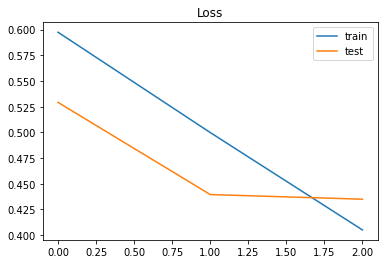

In [39]:
import matplotlib.pyplot as plt

plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

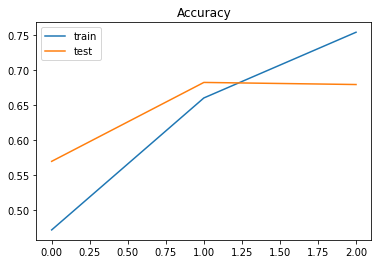

In [41]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();